In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.4MB/s 


1. Import Modules and Libraries

In [1]:
# Import modules
from sklearn.datasets import fetch_openml
import numpy as np
from numpy import expand_dims
from sklearn.model_selection import train_test_split

# For windows laptops add following 2 lines:
import matplotlib
matplotlib.use('agg')

import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import os
import random as rn
import cv2
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.utils.np_utils import to_categorical
import kerastuner as kt

np.random.seed(123)
tf.random.set_seed(123)

2. Load Data and Preprocessing

In [2]:
# Connect Google Drive to import and load image datasets

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!unzip '/content/drive/MyDrive/DL_Project/no_pothole_v2.zip'

In [ ]:
%%capture
!unzip '/content/drive/MyDrive/DL_Project/potholes.zip'

In [3]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass
              
def assign_label(img,label):
    return label

In [4]:
X=[]
Z=[]
IMG_SIZE=250

no_potholes='../content/no_pothole_v2/'
potholes='../content/potholes/'

make_train_data('NO POTHOLES',no_potholes)
make_train_data('POTHOLES',potholes)

100%|██████████| 718/718 [00:07<00:00, 91.05it/s]


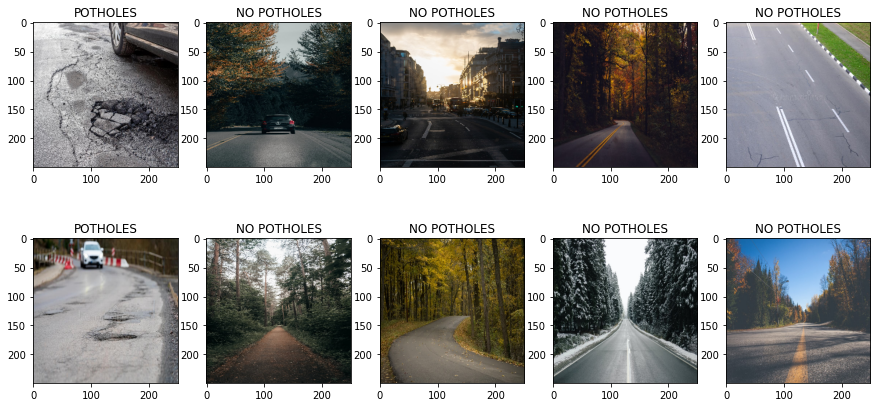

In [5]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(15,15)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:,:,::-1])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

le=LabelEncoder()
Y=le.fit_transform(Z)

#Y=to_categorical(Y)
print(Y)
X=np.array(X)
X=X/255

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state=42)

[0 0 0 ... 1 1 1]


In [7]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(1534, 250, 250, 3)
(1303, 250, 250, 3)
(231, 250, 250, 3)


In [8]:
# Build Model

def model_builder(hp):
  model = Sequential()

  # Tune the number of filters and dropout in the first convolution layer
  hp_filt1 = hp.Choice('filters1', values=[16,32,64])  
  hp_do1 = hp.Choice('do1', values=[0.1,0.2,0.3])

  model.add(Conv2D(filters = hp_filt1, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = (250, 250, 3)))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(hp_do1))

  # Tune the number of filters and in the second convolution layer
  hp_filt2 = hp.Choice('filters2', values=[16,32,64]) 
  
  model.add(Conv2D(filters = hp_filt2, kernel_size = (3,3), padding = 'Same', activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(Flatten())

  # Tune the number of units in the first Dense layer, between 32 and 512
  hp_units = hp.Int('units', min_value=32, max_value=320, step=32)

  model.add(Dense(units=hp_units, activation='relu'))
  
  model.add(Dense(1,  activation = "sigmoid"))

  # Tune the learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = hp_learning_rate), metrics=['accuracy'])

  model.summary()

  return model

In [9]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     seed=123,
                     overwrite=True)

# tuner = kt.RandomSearch(model_builder,
#                         objective='val_accuracy',
#                         max_trials=50,
#                         seed=123,
#                         overwrite=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1

In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [11]:
tuner.search(X_train, Y_train, epochs=50, validation_split=0.15, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete:
Optimal number of filters for layer 1: {best_hps.get('filters1')}
Optimal dropout rate for layer 1: {best_hps.get('do1')}

Optimal number of filters for layer 2: {best_hps.get('filters2')}

The optimal number of units in the first dense layer is {best_hps.get('units')}
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}
""")

Trial 90 Complete [00h 00m 34s]
val_accuracy: 0.8928571343421936

Best val_accuracy So Far: 0.9132652878761292
Total elapsed time: 00h 23m 29s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete:
Optimal number of filters for layer 1: 16
Optimal dropout rate for layer 1: 0.1

Optimal number of filters for layer 2: 64

The optimal number of units in the first dense layer is 256
The optimal learning rate for the optimizer is 0.0001



In [12]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=50, validation_split=0.15)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

In [13]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, Y_train, epochs=best_epoch, validation_split=0.15)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

In [15]:
# Evaluate model
# This model has ran on the full 50 epochs

test_loss, test_accuracy = model.evaluate(X_test, Y_test)

print("Test Loss: {:.3f}, Test Accuracy: {:.3f}".format(test_loss, test_accuracy))


8/8 [==============================] - 0s 13ms/step - loss: 0.5280 - accuracy: 0.8831
Test Loss: 0.528, Test Accuracy: 0.883


In [16]:
# evaluate hypermodel
# Trained on the "best_epoch" number of epochs

test_loss, test_accuracy = hypermodel.evaluate(X_test, Y_test)

print("Test Loss: {:.3f}, Test Accuracy: {:.3f}".format(test_loss, test_accuracy))


8/8 [==============================] - 0s 13ms/step - loss: 0.3857 - accuracy: 0.8485
Test Loss: 0.386, Test Accuracy: 0.848


In [17]:
# Generate Classification Report
from sklearn.metrics import classification_report

y_pred = hypermodel.predict(X_test)

target_names = ['No Pothole', 'Pothole']

print(classification_report(Y_test, y_pred.round(), target_names=target_names))

              precision    recall  f1-score   support

  No Pothole       0.93      0.77      0.84       120
     Pothole       0.79      0.94      0.86       111

    accuracy                           0.85       231
   macro avg       0.86      0.85      0.85       231
weighted avg       0.86      0.85      0.85       231



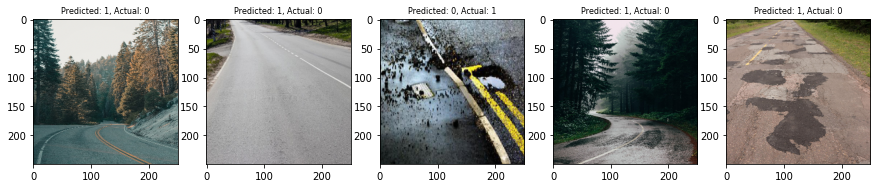

In [18]:
# Assigning the predicted and actual outputs to a class (0 or 1)
Y_pred_classes = y_pred.round()
Y_test_classes = Y_test.round()

# Creating a blank list for all incorrect predictions
inc_pred = []
    
# Comparing the predicted and actual outputs and adding the index of the incorrect predictions to the inc_pred list
for x in range(0,len(Y_pred_classes)):
  if Y_pred_classes[x] != Y_test_classes[x]:
    inc_pred.append(x)

# Creating a sample of the first five (5) incorrect predictions
inc_pred_sample = inc_pred[:5]
inc_pred_sample2 = inc_pred[5:10]

# Plotting the sample of five (5) incorrect predictions
n_plots = len(inc_pred_sample2)

f, ax2=plt.subplots(1, 5, figsize=(20,20))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
f.set_size_inches(15,15)

for i in range(0,n_plots):
    value = X_test[inc_pred_sample2[i]][:,:,::-1]
    ax2[i].imshow(value.reshape(250,250,3))
    ax2[i].set_title("Predicted: {}, Actual: {}".format(int(Y_pred_classes[inc_pred_sample2[i]][0]),Y_test_classes[inc_pred_sample2[i]]), fontsize=8)
    ax2[i].set_aspect('equal')


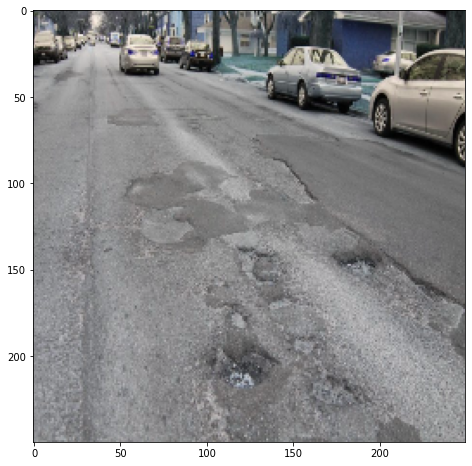

In [19]:
# import random image

test_path = '../content/test_image13.jpg'

test_img = cv2.imread(test_path,cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (IMG_SIZE,IMG_SIZE))

fig1,ay=plt.subplots(1,1)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig1.set_size_inches(15,15)

ay.imshow(test_img)

In [20]:
test_img_dim = expand_dims(test_img, axis=0)

test_img_dim.shape

(1, 250, 250, 3)

In [21]:
# predict class of random image

test_pred = hypermodel.predict(test_img_dim)

print(test_pred)

prediction = test_pred.round()

print(prediction)

if prediction == 0:
  print("This image has no potholes")

else:
  print("This image has potholes")

[[1.]]
[[1.]]
This image has potholes
